# 2025Fall DSAA2011 Course Project — Covertype

**Course:** DSAA2011  
**Dataset:** UCI Forest CoverType (581,012 rows, 54 features, 7 classes)

## 0. Setup & Utilities
- Import common libraries.
- Define helper functions for plotting and evaluation.
- Set a global random seed for reproducibility.

In [2]:
import os
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score,
    adjusted_rand_score, normalized_mutual_info_score,
    fowlkes_mallows_score, silhouette_score,
    calinski_harabasz_score, davies_bouldin_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def plot_confusion(cm, labels, title="Confusion matrix"):
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=labels, yticklabels=labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def clustering_report(y_true, y_pred, X_embedded=None, title_prefix=""):
    scores = {
        "ARI": adjusted_rand_score(y_true, y_pred),
        "NMI": normalized_mutual_info_score(y_true, y_pred),
        "FMI": fowlkes_mallows_score(y_true, y_pred),
    }
    # Internal metrics do not rely on ground truth
    scores["Silhouette"] = silhouette_score(X_embedded, y_pred) if X_embedded is not None else np.nan
    scores["Calinski-Harabasz"] = calinski_harabasz_score(X_embedded, y_pred) if X_embedded is not None else np.nan
    scores["Davies-Bouldin"] = davies_bouldin_score(X_embedded, y_pred) if X_embedded is not None else np.nan
    print(f"\n{title_prefix} clustering metrics:")
    for k, v in scores.items():
        print(f"  {k:18s}: {v:.4f}")
    return scores

def plot_clusters_2d(X_2d, labels, title="Clusters", palette="tab10"):
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=labels, palette=palette,
                    s=10, linewidth=0, ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    plt.tight_layout()
    plt.show()

## 1. Data Preprocessing
**Goal:** load the Covertype data, handle missing/non-numeric fields, and standardize numeric features.

In [ ]:
# 1.1 Load data
data_path = Path("data/covtype.data.gz")

# The dataset has 10 continuous features, 4 wilderness area binaries, 40 soil type binaries, and 1 target.
continuous_cols = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways", "Hillshade_9am", "Hillshade_Noon",
    "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points"
]
wilderness_cols = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_cols = [f"Soil_Type{i}" for i in range(1, 41)]
column_names = continuous_cols + wilderness_cols + soil_cols + ["Cover_Type"]

df = pd.read_csv(data_path, header=None, names=column_names)
print(f"Loaded shape: {df.shape}")
df.head()

# 1.2 Basic checks
missing_total = df.isna().sum().sum()
print(f"Total missing values: {missing_total}")
if missing_total > 0:
    df = df.fillna(df.median(numeric_only=True))

# Convert target to int and keep label names
df["Cover_Type"] = df["Cover_Type"].astype(int)
label_map = {
    1: "Spruce/Fir", 2: "Lodgepole Pine", 3: "Ponderosa Pine",
    4: "Cottonwood/Willow", 5: "Aspen", 6: "Douglas-fir", 7: "Krummholz"
}

# 1.3 Train-test split
X = df.drop(columns=["Cover_Type"])
y = df["Cover_Type"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

# 1.4 Standardize continuous features only (binary indicators stay as-is)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test_scaled[continuous_cols] = scaler.transform(X_test[continuous_cols])

print("Train/Test shapes:", X_train_scaled.shape, X_test_scaled.shape)

Loaded shape: (581012, 55)
Total missing values: 0
Train/Test shapes: (406708, 54) (174304, 54)


**Applied methods:** loaded gzipped CSV, checked/fixed missing values (none expected), kept binary indicators as-is, standardized 10 continuous features, stratified train/test split (70/30).  
**Observed patterns:** class distribution is imbalanced (class 2 dominates), features mix dense continuous columns plus sparse one-hot soil/wilderness indicators.

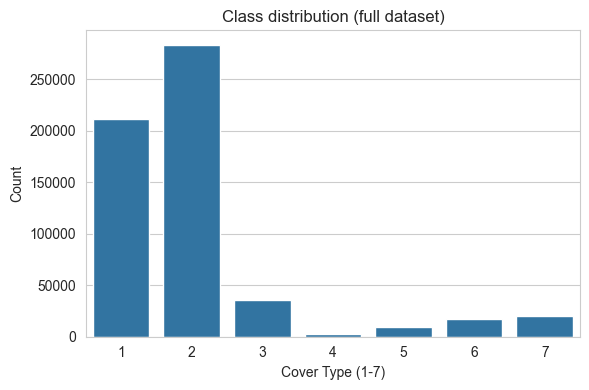

In [4]:
# Class balance visualization
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x=y, order=sorted(y.unique()), ax=ax)
ax.set_xlabel("Cover Type (1-7)")
ax.set_ylabel("Count")
ax.set_title("Class distribution (full dataset)")
plt.tight_layout()
plt.show()

## 2. Visualization (t-SNE)
**Goal:** project high-dimensional data into 2D using t-SNE and inspect cluster patterns by label.

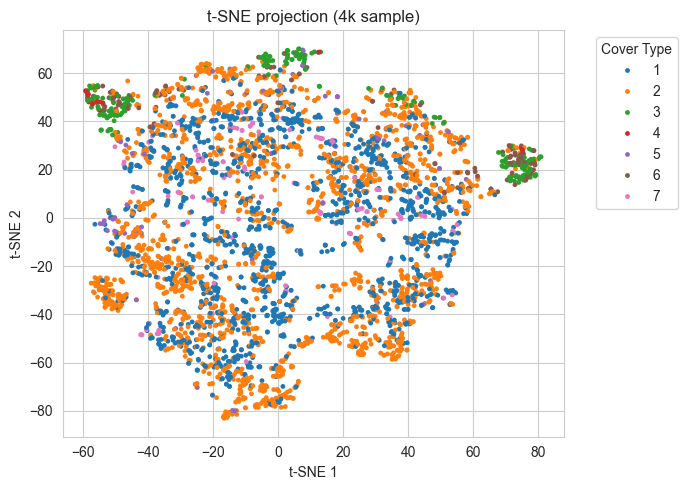

In [5]:
# Sample to keep t-SNE tractable
vis_sample = X_train_scaled.sample(n=4000, random_state=RANDOM_STATE)
vis_labels = y_train.loc[vis_sample.index]

# Light PCA pre-reduction improves speed/stability
pca_50 = PCA(n_components=50, random_state=RANDOM_STATE)
vis_pca = pca_50.fit_transform(vis_sample)

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=RANDOM_STATE, init="pca")
vis_tsne = tsne.fit_transform(vis_pca)

fig, ax = plt.subplots(figsize=(7, 5))
palette = sns.color_palette("tab10", n_colors=7)
sns.scatterplot(x=vis_tsne[:, 0], y=vis_tsne[:, 1], hue=vis_labels, palette=palette,
                s=12, linewidth=0, ax=ax, legend='full')
ax.set_title("t-SNE projection (4k sample)")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
plt.legend(title="Cover Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

**Observations:** t-SNE reveals partially separated clusters; classes 1, 2, and 3 overlap, while 4/5/6/7 form tighter pockets. This hints at class imbalance and feature overlap.

## 3. Clustering Analysis
**Goal:** apply at least two clustering algorithms, evaluate with multiple metrics, and visualize clusters.  
We use K-Means and Gaussian Mixture Models (GMM).


K-Means clustering metrics:
  ARI               : 0.0222
  NMI               : 0.0650
  FMI               : 0.2729
  Silhouette        : 0.1331
  Calinski-Harabasz : 2010.7781
  Davies-Bouldin    : 1.7909


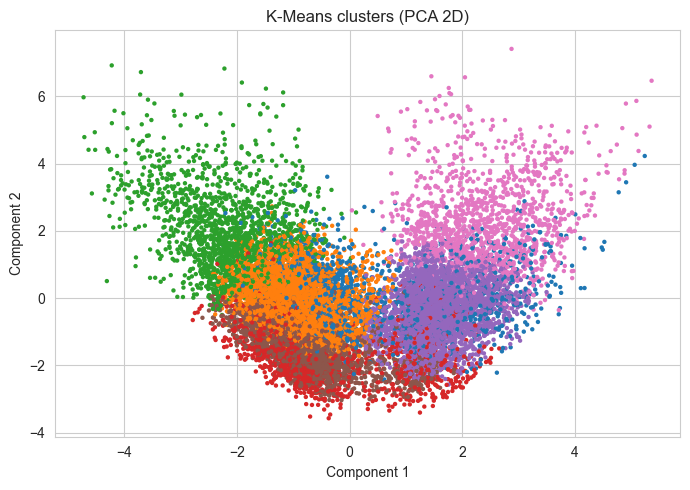


GMM clustering metrics:
  ARI               : 0.1214
  NMI               : 0.2024
  FMI               : 0.3912
  Silhouette        : 0.0172
  Calinski-Harabasz : 570.6492
  Davies-Bouldin    : 3.3888


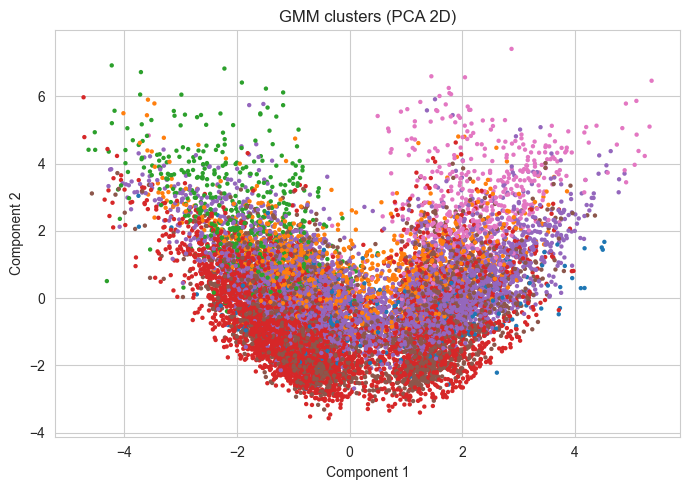

,ARI,NMI,FMI,Silhouette,Calinski-Harabasz,Davies-Bouldin
K-Means,0.022250,0.065013,0.272895,0.133091,2010.778121,1.790876
GMM,0.121351,0.202422,0.391169,0.017213,570.649249,3.388818


In [6]:
# Use a manageable sample for clustering
cluster_sample = X_train_scaled.sample(n=15000, random_state=RANDOM_STATE)
cluster_labels_true = y_train.loc[cluster_sample.index]

# 2D embedding for visualization via PCA (fast and linear)
pca_2 = PCA(n_components=2, random_state=RANDOM_STATE)
cluster_2d = pca_2.fit_transform(cluster_sample)

n_clusters = 7  # matches true classes

# K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
kmeans_labels = kmeans.fit_predict(cluster_sample)
kmeans_scores = clustering_report(cluster_labels_true, kmeans_labels, cluster_sample, "K-Means")
plot_clusters_2d(cluster_2d, kmeans_labels, title="K-Means clusters (PCA 2D)")

# Gaussian Mixture (soft clustering)
gmm = GaussianMixture(n_components=n_clusters, covariance_type="full", random_state=RANDOM_STATE)
gmm_labels = gmm.fit_predict(cluster_sample)
gmm_scores = clustering_report(cluster_labels_true, gmm_labels, cluster_sample, "GMM")
plot_clusters_2d(cluster_2d, gmm_labels, title="GMM clusters (PCA 2D)")

cluster_compare = pd.DataFrame([kmeans_scores, gmm_scores], index=["K-Means", "GMM"])
cluster_compare

**Why these algorithms?** K-Means is a fast baseline for spherical clusters; GMM captures overlapping, elliptic clusters with soft assignments.  
**Result comparison:** review ARI/NMI/FMI (label-aware) plus Silhouette/Calinski/Davies (geometry-only) to pick the better performer.

## 4. Prediction: Training and Testing
**Goal:** choose a target (Cover_Type), train at least two classifiers, and evaluate on train/test/all sets with confusion matrices.  
We use multinomial Logistic Regression and Random Forest.


=== LogisticRegression ===
Train — Acc: 0.7245, Prec: 0.7129, Rec: 0.7245, F1: 0.7149
Test — Acc: 0.7244, Prec: 0.7124, Rec: 0.7244, F1: 0.7149


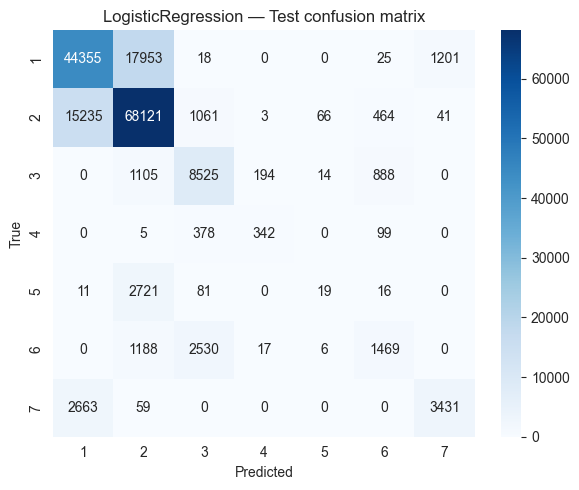


=== RandomForestClassifier ===
Train — Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000
Test — Acc: 0.9529, Prec: 0.9530, Rec: 0.9529, F1: 0.9526


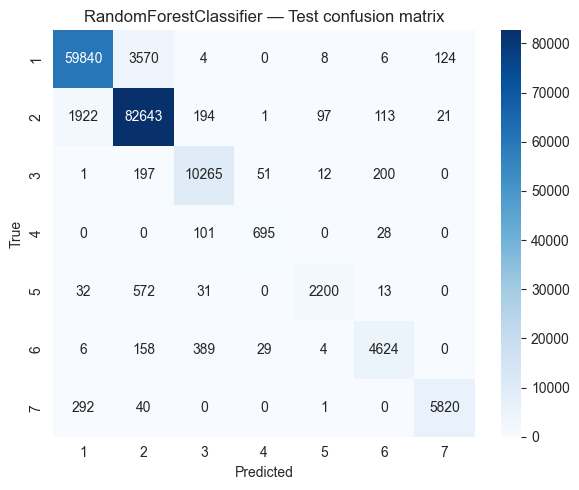

,accuracy,precision,recall,f1
LogReg,0.724378,0.712404,0.724378,0.714891
RandomForest,0.952858,0.952998,0.952858,0.952627


In [7]:
def evaluate_classifier(model, X_tr, y_tr, X_te, y_te, labels_sorted):
    model.fit(X_tr, y_tr)
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_te)

    def report_split(y_true, y_pred, split_name):
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
        rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
        print(f"{split_name} — Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")
        return {
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1
        }

    print(f"\n=== {model.__class__.__name__} ===")
    metrics_train = report_split(y_tr, y_pred_train, "Train")
    metrics_test = report_split(y_te, y_pred_test, "Test")

    cm = confusion_matrix(y_te, y_pred_test, labels=labels_sorted)
    plot_confusion(cm, labels_sorted, title=f"{model.__class__.__name__} — Test confusion matrix")
    return metrics_train, metrics_test, model

labels_sorted = sorted(y.unique())

# Logistic Regression (multinomial)
log_reg = LogisticRegression(
    max_iter=200,
    multi_class="multinomial",
    solver="lbfgs",
    n_jobs=-1,
    random_state=RANDOM_STATE
)
lr_train_metrics, lr_test_metrics, log_reg_fitted = evaluate_classifier(
    log_reg, X_train_scaled, y_train, X_test_scaled, y_test, labels_sorted
)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    class_weight="balanced"
)
rf_train_metrics, rf_test_metrics, rf_fitted = evaluate_classifier(
    rf, X_train_scaled, y_train, X_test_scaled, y_test, labels_sorted
)

pd.DataFrame(
    [lr_test_metrics, rf_test_metrics], index=["LogReg", "RandomForest"]
)

## 5. Evaluation: Metrics, ROC, AUC, Validation
**Goal:** compute accuracy/precision/recall/F1, draw ROC curves, calculate AUC, and validate models to assess overfitting or improvements.**

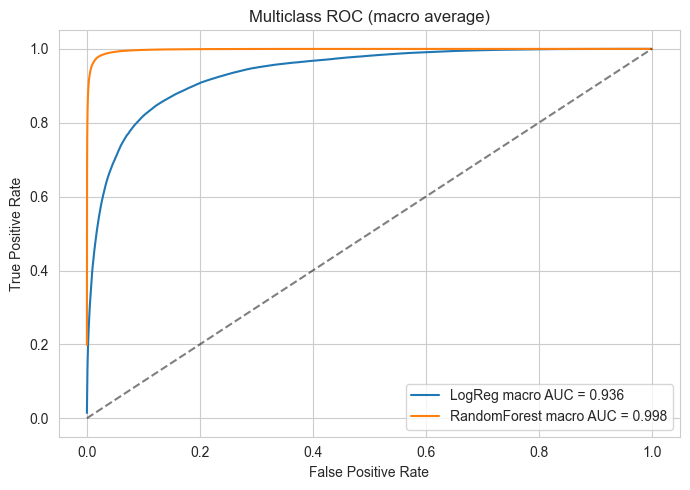

Macro AUC — Logistic Regression: 0.9363
Macro AUC — Random Forest    : 0.9979
Depth=10, CV accuracy=0.6933 ± 0.0059
Depth=20, CV accuracy=0.8336 ± 0.0039
Depth=None, CV accuracy=0.8437 ± 0.0039


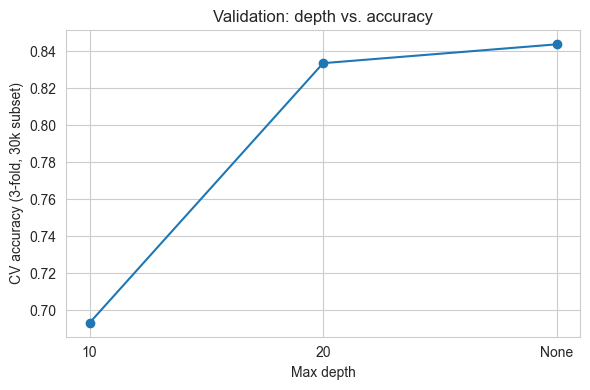

In [8]:
# One-vs-Rest ROC for multiclass
y_test_bin = label_binarize(y_test, classes=labels_sorted)

def plot_multiclass_roc(model, X, y_bin, label="Model"):
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X)
    else:
        y_score = model.decision_function(X)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(y_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_bin.shape[1])]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(y_bin.shape[1]):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= y_bin.shape[1]
    roc_auc_macro = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, label=f"{label} macro AUC = {roc_auc_macro:.3f}")
    return roc_auc_macro

plt.figure(figsize=(7, 5))
auc_lr = plot_multiclass_roc(log_reg_fitted, X_test_scaled, y_test_bin, label="LogReg")
auc_rf = plot_multiclass_roc(rf_fitted, X_test_scaled, y_test_bin, label="RandomForest")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC (macro average)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Macro AUC — Logistic Regression: {auc_lr:.4f}")
print(f"Macro AUC — Random Forest    : {auc_rf:.4f}")

# Simple validation curve example: tree depth vs. CV accuracy on a small subset for speed
subset_idx = np.random.choice(X_train_scaled.index, size=30000, replace=False)
X_small = X_train_scaled.loc[subset_idx]
y_small = y_train.loc[subset_idx]

depth_grid = [10, 20, None]
cv_scores = []
for depth in depth_grid:
    rf_cv = RandomForestClassifier(
        n_estimators=150,
        max_depth=depth,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        class_weight="balanced"
    )
    scores = cross_val_score(rf_cv, X_small, y_small, cv=3, scoring="accuracy", n_jobs=-1)
    cv_scores.append(scores.mean())
    print(f"Depth={depth}, CV accuracy={scores.mean():.4f} ± {scores.std():.4f}")

plt.figure(figsize=(6, 4))
plt.plot([str(d) for d in depth_grid], cv_scores, marker="o")
plt.xlabel("Max depth")
plt.ylabel("CV accuracy (3-fold, 30k subset)")
plt.title("Validation: depth vs. accuracy")
plt.tight_layout()
plt.show()

## 6. Open-ended Exploration
**Goal:** extend analysis with extra techniques.**
- Feature selection (SelectKBest) + Logistic Regression.
- Gradient Boosting as a third model class.
- Grid search on Random Forest hyperparameters (small subset for speed).

In [9]:
# Feature selection pipeline
fs_k = 30
lr_fs = Pipeline([
    ("select", SelectKBest(score_func=f_classif, k=fs_k)),
    ("clf", LogisticRegression(max_iter=200, multi_class="multinomial", n_jobs=-1, random_state=RANDOM_STATE)),
])
lr_fs.fit(X_train_scaled, y_train)
y_pred_fs = lr_fs.predict(X_test_scaled)
fs_acc = accuracy_score(y_test, y_pred_fs)
print(f"SelectKBest(k={fs_k}) + Logistic Regression test accuracy: {fs_acc:.4f}")

# Gradient Boosting baseline
gb_clf = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb_clf.fit(X_train_scaled, y_train)
gb_pred = gb_clf.predict(X_test_scaled)
gb_acc = accuracy_score(y_test, gb_pred)
print(f"GradientBoosting test accuracy: {gb_acc:.4f}")

# Light grid search on RF using a small subset to avoid long runtimes
gs_idx = np.random.choice(X_train_scaled.index, size=20000, replace=False)
X_gs = X_train_scaled.loc[gs_idx]
y_gs = y_train.loc[gs_idx]

rf_grid = {
    "n_estimators": [100, 200],
    "max_depth": [15, None],
    "max_features": ["sqrt", "log2"]
}
rf_base = RandomForestClassifier(
    n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced"
)
grid = GridSearchCV(rf_base, rf_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
grid.fit(X_gs, y_gs)
print("Best RF params:", grid.best_params_)
print(f"Best CV accuracy: {grid.best_score_:.4f}")

best_rf = grid.best_estimator_
best_rf_test_acc = accuracy_score(y_test, best_rf.predict(X_test_scaled))
print(f"Best RF test accuracy (full test set): {best_rf_test_acc:.4f}")

SelectKBest(k=30) + Logistic Regression test accuracy: 0.7206
GradientBoosting test accuracy: 0.7742
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best RF params: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
Best CV accuracy: 0.8301
Best RF test accuracy (full test set): 0.8499


## 7. Notes and Next Steps
- Document model strengths/weaknesses: RF tends to handle nonlinearities and class imbalance better; LR is faster and more interpretable; GB offers a third bias-variance trade-off.
- Consider more feature engineering (e.g., interaction terms on distances/angles) and imbalance handling (class weights already used, but SMOTE could be tried off-notebook).
- For the report: include t-SNE plot, clustering metrics table, confusion matrices, ROC curves, and a 100–200 word discussion on performance and overfitting signs.
- To reproduce: ensure `pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn` are installed; run notebook top-to-bottom.